This code uses the scikit-learn framework with the yellowbrick module to analyze the predictive power of the signal with respect to spy_close_price in the given stock market data. Runtime error will occur if scikit-learn and yellowbrick are not installed.<br>
Yellowbrick can be installed by running the following command: **conda install -c districtdatalabs yellowbrick**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import datetime
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import Ridge

In [13]:
input_path = './data.csv' 
df = pd.read_csv(input_path) #read the data from the supplied file
print(df.head())

       date    signal  spy_close_price
0  20120103  3.107767          127.495
1  20120104  3.107282          127.700
2  20120105  3.099757          128.040
3  20120106  3.134223          127.710
4  20120109  3.135922          128.020


Before we can make any predictions with the signal, we need to make sure that the data is clean. The first step we took to clean the data was to identify whether there are any missing values in the data.

In [14]:
#Check for missing values
if df.isnull().values.any():
    print("There are missing values in data.csv\n")
    print(df.isnull().sum())
else:
    print("There are no missing values in data.csv\n")

There are no missing values in data.csv



From the code above, we see that there are no missing values in the data.

Since all values are susceptible to corruption, we have to do some checking and cleaning on each column.The stock market is only open on the weekdays, so there should not be any dates on the weekend. If there are any weekday entries, we will delete them as they do not belong. To check for this, we converted the date column to a datetime and used a built-in function to check to see if any dates were weekends.



In [15]:
#Checked all dates are weekdays
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df["weekday"] = df["date"].dt.weekday
baddays = df.query("weekday > 4")
baddays

,date,signal,spy_close_price,weekday
525,2014-02-08,4.466505,179.68,5
526,2014-02-09,4.466505,179.68,6


We see that there are two entries that occur on weekend. The stock market should not open during those dates, so we are going to drop those indexes

In [16]:
#drop the bad rows
df = df.drop([525,526],axis=0)
#drop the weekday column that we added just before as it is not used in our prediction
df = df.drop(['weekday'],axis=1)
#the number of rows should now be 667-2, or 665
df.shape

(665, 3)

Now, to get rid of outliers in the data. We began by calculating the mean and standard deviation of the spy_close_price column. We deemed any value that is more than two standard deviations from the mean, while neither the preceding nor the following row value is, to be an outlier. To clean up such a value, we first converted such values to NaN and replaced them using the interpolate function with the linear method.

In [17]:
spy_mean = df['spy_close_price'].mean()
spy_std = df['spy_close_price'].std()

def setBadSpyToNaN(val):
    if (val > spy_mean + 2*spy_std) or (val < spy_mean - 2*spy_std): 
        val = np.nan
    return val

#first set all values of spy_close_price that are more than two std away from mean to NaN
df["spy_close_price"] = df["spy_close_price"].apply(setBadSpyToNaN)
#use the interpolate method to fill in the NaN values
df["spy_close_price"] = df["spy_close_price"].interpolate()

After we eliminated any outliers in the spy_close_price, we are going to plot the date vs spy_close_price. The graph would be smoother without any outlier values.


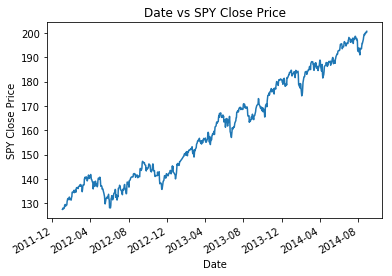

In [95]:
#plot date vs spy_close_price
plt.plot(df['date'].values,df['spy_close_price'].values)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("SPY Close Price")
plt.title("Date vs SPY Close Price")
plt.show()

Now, we plot Date vs Signal to check for outliers in the signal.

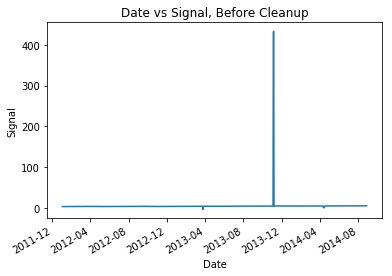

In [96]:
#plot date vs signal
plt.plot(df['date'].values,df['signal'].values)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title('Date vs Signal, Before Cleanup')
plt.show()

We see from the above graph that there are some outliers in the signal. Hence, we will clean up the signal values using the same methodolgy as we used for the spy_close_price. The only difference is that we determined the cutoff values for outliers by observing the given data since the standard deviation was too large to be used.

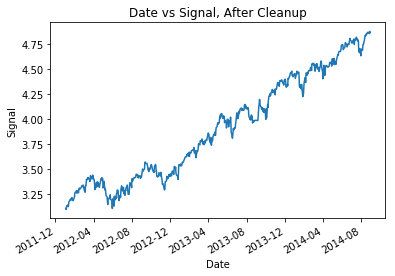

In [97]:
#unable to use mean and std for this, used best judgement based on observing the data
def setBadSignalToNaN(val):
    if (val > 10) or (val < 2): 
        val = np.nan
    return val

#first set all the bad values to NaN
df["signal"] = df["signal"].apply(setBadSignalToNaN)
#use the interpolate method to fill in
df["signal"] = df["signal"].interpolate()

plt.plot(df['date'].values,df['signal'].values)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title('Date vs Signal, After Cleanup')
plt.show()

After cleaning up the signal and plotting it we see that the two graphs look very similar, so we know that the data has been properly cleaned up. <br>
For my analysis, we used linear regession model to test the predictive abilties of the signal with respect to spy_close_price. 

We split the signal and spy_close_price into a feature matrix and a response vector. Then we split the data into a test set and a training set.

In [26]:
#feature matrix
x = df[['signal']]

#respose vector
y = df['spy_close_price']

# Split our data
x_train, x_test, y_train, y_test  = train_test_split(x,y)

Now we normalize our data. 

In [27]:
scaler = StandardScaler()
# Fit to the training data
scaler.fit(x_train)

# Now apply the transformations to the data:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

We used linear regression from the linear_model module to fit our training data.

In [117]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Next we predict our result using our testing set.

In [118]:
y_pred = regr.predict(x_test)

Next we calculate the mean squared error and the r-squared value to see how if the model is a good fit for our data.

In [127]:

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared = : %.2f' % r2_score(y_test, y_pred))

Mean squared error: 3.83
R-squared = : 0.99


We get the value of r-sqaured to be 0.99 or 99% which indicates that our model is good fit for our data and the signal has a almost perfect prediction power for the spy_close_price.

Additionally, we plot our regression line to see how close our spy_close_price is to our model.

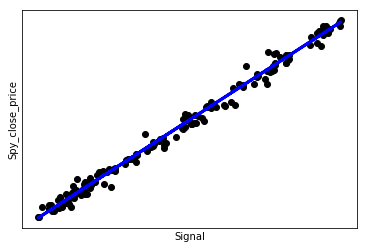

In [128]:
# Plot outputs
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)
plt.xlabel("Signal")
plt.ylabel("Spy_close_price")

plt.xticks(())
plt.yticks(())

plt.show()

The above plot indicates that the data is very close to the fitted regression line.

However, high r-squared value doesn't always mean a good fit. Therefore, we do a residual plot on our data to see if linear regression is indeed a good fit for our data.

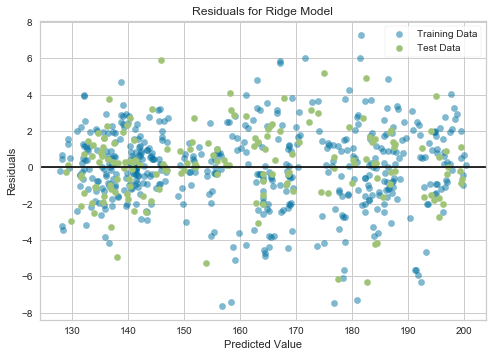

In [131]:
# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

After doing a residual plot, we see that our data points are randomly scattered along the horizontal axis. This indicates a good fit and shows that linear regression is indeed a good model for our data.